# Quantum Key Distribution - E91

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy.random import randint, choice
import numpy as np
import math
print("Imports Successful")

Imports Successful


Original code, which explained the BB84 protocol, sourced from: 

https://qiskit.org/textbook/ch-algorithms/quantum-key-distribution.html

A relevant discussion of E91: 

https://en.wikipedia.org/wiki/Quantum_key_distribution#E91_protocol:_Artur_Ekert_.281991.29

A listing of available Qiskit gates:

https://qiskit.org/textbook/ch-states/single-qubit-gates.html#1.2-The-Y-&-Z-gates--

A video on the CHSH inequality, which is pertinent to why E91 is useful:

https://www.youtube.com/watch?v=sUQYSy6C1aA

## Contents

1. Introduction
2. Theory Demonstration
3. Protocol Overview
4. Qiskit Example
5. Simplified Complete Qiskit Example
5. What happens when Eve entangles a third qubit?
6. What happens when the angle intervals are changed?

## 1. Introduction

When Alice and Bob want to communicate a secret message (such as Bob’s online banking details) over an insecure channel (such as the internet), its essential to encrypt the message. Since cryptography is a large area and almost all of it is outside the scope of this textbook, we will have to believe that Alice and Bob having a secret key that no-one else knows is useful and allows them to communicate using symmetric-key cryptography.

If Alice and Bob want to use Eve’s classical communication channel to share their key, it is impossible to tell if Eve has made a copy of this key for herself- they must place complete trust in Eve that she is not listening. If, however, Eve provides a quantum communication channel, Alice and Bob no longer need to trust Eve at all- they will know if she tries to read Bob’s message before it gets to Alice.

For some readers, it may be useful to give an idea of how a quantum channel may be physically implemented. An example of a classical channel could be a telephone line; we send electric signals through the line that represent our message (or bits). A proposed example of a quantum communication channel could be some kind of fibre-optic cable, through which we can send individual photons (particles of light). Photons have a property called _polarisation,_ and this polarisation can be one of two states. We can use this to represent a qubit.


## 2. Theory Demonstration

The protocol makes use of the fact that measuring a qubit can change its state. If Alice sends Bob a qubit, and an eavesdropper (Eve) tries to measure it before Bob does, there is a chance that Eve’s measurement will change the state of the qubit and Bob will not receive the qubit state Alice sent.  

In [2]:
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy.random import randint, choice
import numpy as np
print("Imports Successful")

Imports Successful


If Alice prepares a qubit in the state $|+\rangle$ (`0` in the X-basis), and Bob measures it in the X-basis, Bob is sure to measure `0`:

┌───┐ ░ ┌───┐┌─┐
q_0: ┤ H ├─░─┤ H ├┤M├
     └───┘ ░ └───┘└╥┘
c_0: ══════════════╩═

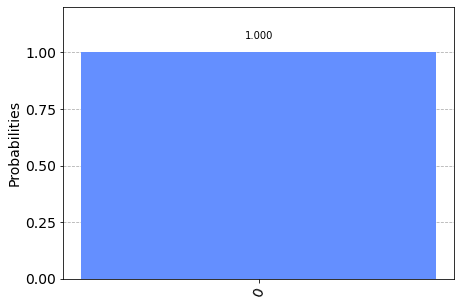

In [3]:
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
qc.barrier()
# Alice now sends the qubit to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

# Draw and simulate circuit
display(qc.draw())
qasm_sim = Aer.get_backend('qasm_simulator')
job = qasm_sim.run(assemble(qc))
plot_histogram(job.result().get_counts())

But if Eve tries to measure this qubit in the Z-basis before it reaches Bob, she will change the qubit's state from $|+\rangle$ to either $|0\rangle$ or $|1\rangle$, and Bob is no longer certain to measure `0`:

┌───┐┌─┐ ░ ┌───┐┌─┐
q_0: ┤ H ├┤M├─░─┤ H ├┤M├
     └───┘└╥┘ ░ └───┘└╥┘
c_0: ══════╩══════════╩═

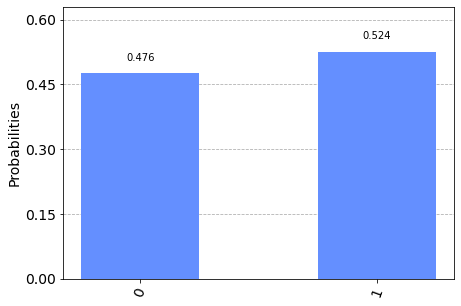

In [4]:
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
# Alice now sends the qubit to Bob
# but Eve intercepts and tries to read it
qc.measure(0, 0)
qc.barrier()
# Eve then passes this on to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

# Draw and simulate circuit
display(qc.draw())
qasm_sim = Aer.get_backend('qasm_simulator')
job = qasm_sim.run(assemble(qc))
plot_histogram(job.result().get_counts())

We can see here that Bob now has a 50% chance of measuring `1`, and if he does, he and Alice will know there is something wrong with their channel. 

This effect occurs in any given non-identical pair of measurement bases:
- The measured result of a mismatched basis will not always match the encoded bit.
- The act of measurement changes a qubit in a predictable way.

Another key concept in the E91 protocol is the EPR pair. An EPR pair is a pair of maximally entangled qubits. Qubits in an EPR pair have the interesting property that after measuring one of them in a given basis, if the paired qubit is measured in that same basis, that second measurement will, with 100% certainty, report a known value. If, however, the second qubit is measured in a different basis, the second measurement will report each possible outcome with known probabilities.

By way of example, let us generate many instances of the $\frac{1}{\sqrt(2)}\big(|00\rangle + |11\rangle\big)$ EPR pair and measure each pair's qubits.

In [5]:
def generate_correlated_epr_pair():
    # Generate a quantum circuit
    qc = QuantumCircuit(2,2)
    # Entangle an EPR pair
    qc.h(0)
    qc.cx(0,1)
    # Return pair
    return qc

┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c_0: ═══════════╩══╬═
                   ║ 
c_1: ══════════════╩═

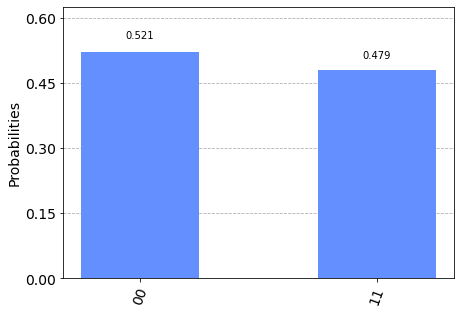

In [6]:
qc = generate_correlated_epr_pair()
# Measure each qubit in turn
qc.measure(0,0)
qc.measure(1,1)
# Display results
display(qc.draw())
qasm_sim = Aer.get_backend('qasm_simulator')
job = qasm_sim.run(assemble(qc))
plot_histogram(job.result().get_counts())

Note that the two outcomes are $|00\rangle$ and $|11\rangle$, in equal amounts. When the first bit is measured a 0, the second is measured a 0; likewise with 1.

What happens if the $\frac{1}{\sqrt(2)}\big(|00\rangle + |11\rangle\big)$ state is measured in some basis other than the standard basis? 

To prepare, let's create some measurement functions at 45 degree angles to one another.

In [7]:
# Four axes of measurement in 45 degree increments

# X axis measurement
def measure_1(qc, qubit, output):
    qc.h(qubit)
    qc.measure(qubit, output)

# 1/sqrt(2) * (X + Z)
def measure_2(qc, qubit, output):
    qc.s(qubit)
    qc.h(qubit)
    qc.t(qubit)
    qc.h(qubit)
    qc.measure(qubit, output)

# Z axis measurement
def measure_3(qc, qubit, output):
    qc.measure(qubit, output)

# 1/sqrt(2) * (-X + Z)
def measure_4(qc, qubit, output):
    qc.s(qubit)
    qc.h(qubit)
    qc.tdg(qubit)
    qc.h(qubit)
    qc.measure(qubit, output)

To save space, let's also abstract the output display function.

In [8]:
def display_qc_output(qc):
    display(qc.draw())
    qasm_sim = Aer.get_backend('qasm_simulator')
    job = qasm_sim.run(assemble(qc))
    return job.result().get_counts()

Let's also make a macro for testing pairs of measurement functions.

In [9]:
def compare_measurements(measure_a, measure_b):
    qc = generate_correlated_epr_pair()
    measure_a(qc, 0, 0)
    measure_b(qc, 1, 1)
    return display_qc_output(qc)

So what happens if we measure our EPR pairs in identical axes?

┌───┐     ┌───┐┌─┐   
q_0: ┤ H ├──■──┤ H ├┤M├───
     └───┘┌─┴─┐├───┤└╥┘┌─┐
q_1: ─────┤ X ├┤ H ├─╫─┤M├
          └───┘└───┘ ║ └╥┘
c_0: ════════════════╩══╬═
                        ║ 
c_1: ═══════════════════╩═

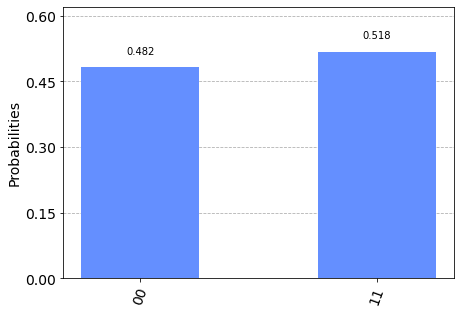

In [10]:
plot_histogram(compare_measurements(measure_1, measure_1))

┌───┐     ┌───┐┌───┐┌───┐┌───┐┌─┐   
q_0: ┤ H ├──■──┤ S ├┤ H ├┤ T ├┤ H ├┤M├───
     └───┘┌─┴─┐├───┤├───┤├───┤├───┤└╥┘┌─┐
q_1: ─────┤ X ├┤ S ├┤ H ├┤ T ├┤ H ├─╫─┤M├
          └───┘└───┘└───┘└───┘└───┘ ║ └╥┘
c_0: ═══════════════════════════════╩══╬═
                                       ║ 
c_1: ══════════════════════════════════╩═

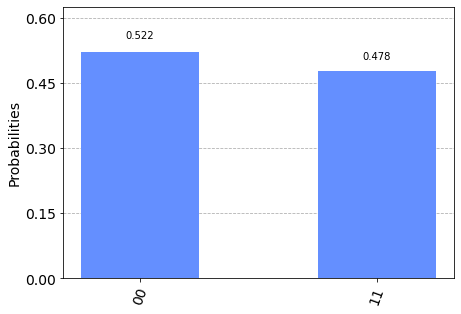

In [11]:
plot_histogram(compare_measurements(measure_2, measure_2))

┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c_0: ═══════════╩══╬═
                   ║ 
c_1: ══════════════╩═

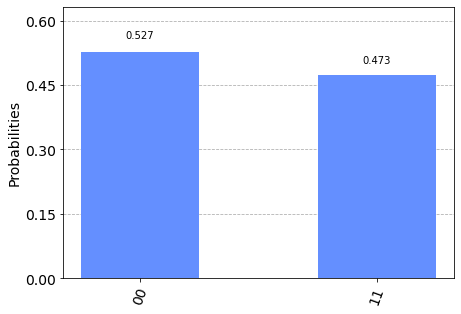

In [12]:
plot_histogram(compare_measurements(measure_3, measure_3))

┌───┐     ┌───┐┌───┐┌─────┐┌───┐┌─┐   
q_0: ┤ H ├──■──┤ S ├┤ H ├┤ TDG ├┤ H ├┤M├───
     └───┘┌─┴─┐├───┤├───┤├─────┤├───┤└╥┘┌─┐
q_1: ─────┤ X ├┤ S ├┤ H ├┤ TDG ├┤ H ├─╫─┤M├
          └───┘└───┘└───┘└─────┘└───┘ ║ └╥┘
c_0: ═════════════════════════════════╩══╬═
                                         ║ 
c_1: ════════════════════════════════════╩═

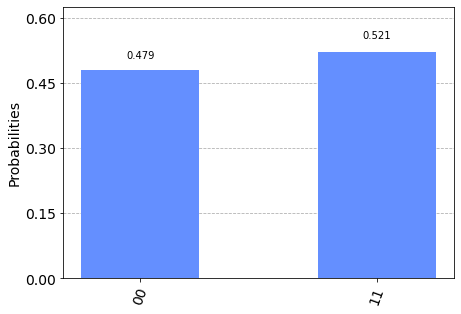

In [13]:
plot_histogram(compare_measurements(measure_4, measure_4))

Clearly, the only measured results, if the bases match, are 00 and 11, i.e. the results are perfectly correlated.

What happens if the bases are 45 degrees apart?

┌───┐     ┌───┐┌─┐                  
q_0: ┤ H ├──■──┤ H ├┤M├──────────────────
     └───┘┌─┴─┐├───┤└╥┘┌───┐┌───┐┌───┐┌─┐
q_1: ─────┤ X ├┤ S ├─╫─┤ H ├┤ T ├┤ H ├┤M├
          └───┘└───┘ ║ └───┘└───┘└───┘└╥┘
c_0: ════════════════╩═════════════════╬═
                                       ║ 
c_1: ══════════════════════════════════╩═

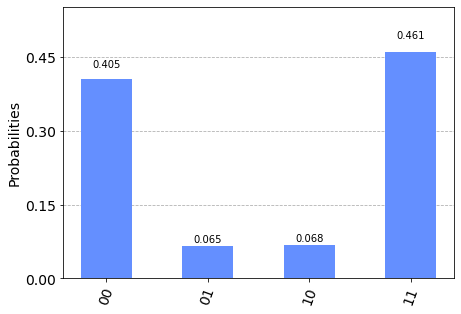

In [14]:
plot_histogram(compare_measurements(measure_1, measure_2))

┌───┐     ┌───┐┌───┐┌───┐┌───┐┌─┐
q_0: ┤ H ├──■──┤ S ├┤ H ├┤ T ├┤ H ├┤M├
     └───┘┌─┴─┐└┬─┬┘└───┘└───┘└───┘└╥┘
q_1: ─────┤ X ├─┤M├─────────────────╫─
          └───┘ └╥┘                 ║ 
c_0: ════════════╬══════════════════╩═
                 ║                    
c_1: ════════════╩════════════════════

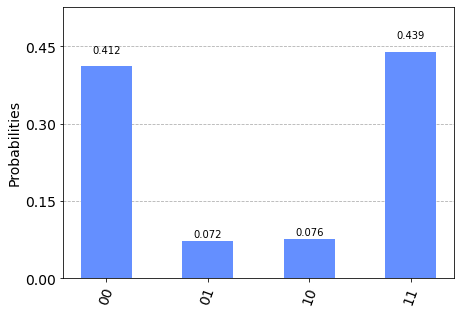

In [15]:
plot_histogram(compare_measurements(measure_2, measure_3))

┌───┐     ┌─┐                         
q_0: ┤ H ├──■──┤M├─────────────────────────
     └───┘┌─┴─┐└╥┘┌───┐┌───┐┌─────┐┌───┐┌─┐
q_1: ─────┤ X ├─╫─┤ S ├┤ H ├┤ TDG ├┤ H ├┤M├
          └───┘ ║ └───┘└───┘└─────┘└───┘└╥┘
c_0: ═══════════╩════════════════════════╬═
                                         ║ 
c_1: ════════════════════════════════════╩═

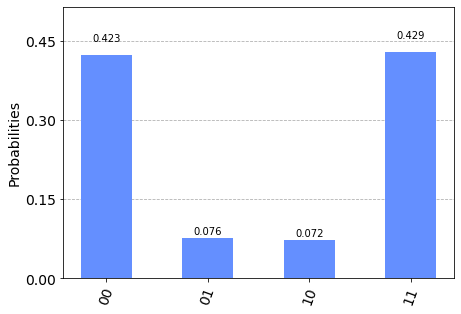

In [16]:
plot_histogram(compare_measurements(measure_3, measure_4))

Clearly, when the bases are 45 degrees apart, only ~85% of readings match.

What happens when bases are 90 degrees apart?

┌───┐     ┌───┐┌─┐
q_0: ┤ H ├──■──┤ H ├┤M├
     └───┘┌─┴─┐└┬─┬┘└╥┘
q_1: ─────┤ X ├─┤M├──╫─
          └───┘ └╥┘  ║ 
c_0: ════════════╬═══╩═
                 ║     
c_1: ════════════╩═════

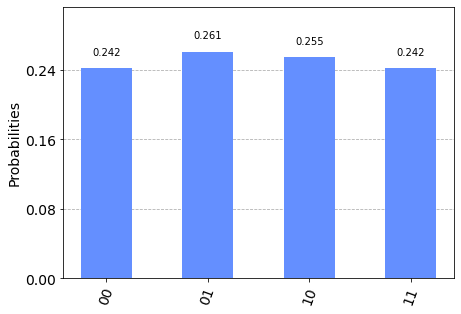

In [17]:
plot_histogram(compare_measurements(measure_1, measure_3))

┌───┐     ┌───┐┌───┐ ┌───┐ ┌───┐┌─┐   
q_0: ┤ H ├──■──┤ S ├┤ H ├─┤ T ├─┤ H ├┤M├───
     └───┘┌─┴─┐├───┤├───┤┌┴───┴┐├───┤└╥┘┌─┐
q_1: ─────┤ X ├┤ S ├┤ H ├┤ TDG ├┤ H ├─╫─┤M├
          └───┘└───┘└───┘└─────┘└───┘ ║ └╥┘
c_0: ═════════════════════════════════╩══╬═
                                         ║ 
c_1: ════════════════════════════════════╩═

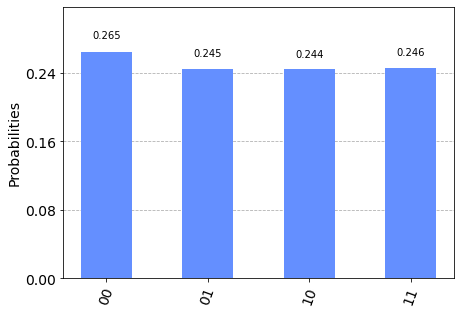

In [18]:
plot_histogram(compare_measurements(measure_2, measure_4))

Clearly, when bases are 90 degrees apart, readings are essentially random, matching only 50% of the time.

What about when bases are 135 degrees apart?

┌───┐     ┌───┐┌─┐                    
q_0: ┤ H ├──■──┤ H ├┤M├────────────────────
     └───┘┌─┴─┐├───┤└╥┘┌───┐┌─────┐┌───┐┌─┐
q_1: ─────┤ X ├┤ S ├─╫─┤ H ├┤ TDG ├┤ H ├┤M├
          └───┘└───┘ ║ └───┘└─────┘└───┘└╥┘
c_0: ════════════════╩═══════════════════╬═
                                         ║ 
c_1: ════════════════════════════════════╩═

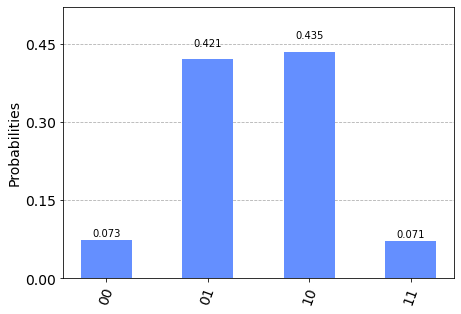

In [19]:
plot_histogram(compare_measurements(measure_1, measure_4))

Clearly, when bases are 135 degrees apart, readings match only 15% of the time. 

For the sake of convenience, let's create a function that can measure at any angle in the XZ plane.

In [20]:
from qiskit.circuit.library.standard_gates import RYGate
from qiskit.circuit import Parameter
qr=QuantumRegister(1)
circ=QuantumCircuit(qr)
a=Parameter('a') # You can replace a with your choice of angle here
CCRY=RYGate(a)
circ.append(CCRY,qr)
print(circ)

#help(qc)

# help(RYGate)

# qc = generate_correlated_epr_pair()
# gate=RYGate(Parameter('pi')) # You can replace a with your choice of angle here
# qc.append(gate)
# plot_histogram(display_qc_output(qc))

      ┌───────┐
q0_0: ┤ RY(a) ├
      └───────┘


The concept critical to the E91 protocol is the [CHSH inequality](https://en.wikipedia.org/wiki/CHSH_inequality), which describes the relationship between measurements of members of EPR pairs taken in bases rotated by known angles, as shown above. The critical aspects are:
- If you measure one qubit in a basis, and you measure its EPR partner in a basis rotated by $\theta$, then the probability that you will measure the same outcome for both qubits in $\cos^2(\theta)$. 
    - $\cos^2(0°) = 1$
    - $\cos^2(45°) = 0.5$
    - $\cos^2(90°) = 0$
    - $\cos^2(135°) = 0.5$
- If you measure two qubits in mismatching bases, and they are NOT in an EPR pair, you will not find such a correlation.
- If you measure two qubits in mismatching bases, and they have been entangled with a third qubit, you will not find such a correlation.

## 3. Protocol Overview

The E91 quantum key distribution protocol involves distributing EPR pairs to Alice and Bob, letting them each measure their qubits along privately-chosen bases, revealing their bases to one another, constructing a valid key from qubit measurements corresonding to matching basis choices, and using the results from non-matching choices in heuristic analyses to find eavesdroppers.

For the sake of simplicity, all EPR pairs here will be in symmetrically entangled states (like $(1/sqrt(2))(|00\rangle + |11\rangle)$ or $(1/sqrt(2))(|++\rangle + |--\rangle)$) rather than complementarily entangled states (like $(1/sqrt(2))(|01\rangle + |10\rangle)$ or $(1/sqrt(2))(|+-\rangle + |-+\rangle)$). (If the pairs were in complementarily entangled states, a simple bit flip post-measurement on Bob's part would be sufficient to keep the protocol intact.)

It is assumed that Alice and Bob have agreed beforehand on lengths of random strings to be generated, number of qubits to destroy in testing, the encoding procedures for each basis, etc.

Detailed steps for the E91 protocol are below.

In [21]:
qubits_count = 50
check_count = 5

**- Step 1**

Alice and Bob choose strings of random bits to be their basis choices. Alice chooses from the bases $Z_0$, $Z_{\pi/8}$, $Z_{\pi/4}$, while Bob chooses from the bases $Z_{-\pi/8}$, $Z_0$, $Z_{\pi/8}$, where $Z_\theta$ is the $\{|+\rangle,|-\rangle\}$ basis rotated by $\theta$.

Let the basis choices $Z_{-\pi/8}$, $Z_0$, $Z_{\pi/8}$, and $Z_{\pi/4}$ correspond to the integers 0 to 3.

In [22]:
alice_basis_choices = ''.join([str(randint(1, 4)) for i in range(qubits_count)])
bob_basis_choices = ''.join([str(randint(0, 3)) for i in range(qubits_count)])
print("Alice's basis choices are:\n", alice_basis_choices)
print("Bob's basis choices are:\n", bob_basis_choices)

Alice's basis choices are:
 21212222312212121223132213312123112213323322313113
Bob's basis choices are:
 11221112011010202201200022212212012000210020112111


Alice and Bob keep these pieces of information private to themselves. 

**- Step 2**

Alice and Bob measure EPR pairs along their previously chosen bases. It does not matter where the EPR pairs come from - they can come from Alice, they can come from Bob, or they can come from an external source Eve. Regardless the EPR pairs' providence, they are measured by Alice and Bob.

In Qiskit, this process will be modeled by generating EPR pair objects and having Alice and Bob measure them. Here, this is modeled by probabalistically generating outcomes, according to pairs of Alice and Bob basis choices.

In [23]:
alice_measurements = []
bob_measurements = []
for alice_basis, bob_basis in zip(alice_basis_choices, bob_basis_choices):
    alice_basis, bob_basis = map(int, [alice_basis, bob_basis])
    # The first measurement is always random:
    primary_measurement = randint(0, 2)
    secondary_measurement = "X"
    # If measurements are aligned:
    if alice_basis == bob_basis:
        secondary_measurement = primary_measurement
    # If measurements are pi/4 apart
    elif abs(alice_basis - bob_basis) == 1:
        pass
    # If measurements are pi/2 apart
    elif abs(alice_basis - bob_basis) == 2:
        secondary_measurement = randint(0, 2)
    # If measurements are 3pi/4 apart
    elif abs(alice_basis - bob_basis) == 3:
        pass
    # Store the measurements
    alice_measurements.append(str(primary_measurement))
    bob_measurements.append(str(secondary_measurement))
alice_measurements = ''.join(alice_measurements)
bob_measurements = ''.join(bob_measurements)
print("Alice's measurements are:\n", alice_measurements)
print("Bob's measurements are:\n", bob_measurements)

Alice's measurements are:
 11101100100111110111000001101011101010101110100101
Bob's measurements are:
 X11XXXX0X0X011X1X110XX10XXX01XXXX011XXXXXX1000X101


**- Step 3**

Alice and Bob reveal their bases to one another and use the new information to generate a secret key from those measurements that were taken in matching bases.

In [24]:
alice_secret_key = ''.join([measurement for measurement, a_choice, b_choice in 
                            zip(alice_measurements, 
                                alice_basis_choices, 
                                bob_basis_choices)
                            if a_choice == b_choice])
bob_secret_key = ''.join([measurement for measurement, a_choice, b_choice in 
                          zip(alice_measurements,
                              alice_basis_choices, 
                              bob_basis_choices)
                          if a_choice == b_choice])
print("Alice's secret key is: \n", alice_secret_key)
print("Bob's secret key is: \n", bob_secret_key)

Alice's secret key is: 
 11001101011010
Bob's secret key is: 
 11001101011010


**- Step 4**

Alice and Bob use their unused measurements (those from mismatched bases) to test [Bell's theorem](https://en.wikipedia.org/wiki/Bell%27s_theorem).

## 4. Qiskit Example

In [25]:
qubits_count = 50
check_count = 5

**- Step 1**

Alice and Bob choose strings of random bits to be their basis choices. Alice chooses from the bases 1-3, while Bob chooses from the bases 2-4. Let the basis choices from measurements 1-4 defined above, i.e. those measurements happening at 45 degree angles, correspond to the integers 1-4.

In [26]:
alice_basis_choices = ''.join([str(randint(1, 4)) for i in range(qubits_count)])
bob_basis_choices = ''.join([str(randint(2, 5)) for i in range(qubits_count)])
print("Alice's basis choices are:\n", alice_basis_choices)
print("Bob's basis choices are:\n", bob_basis_choices)

Alice's basis choices are:
 13321213213223212123231223213313322323111321233221
Bob's basis choices are:
 33443332342323332432443432234343324343222424433234


Alice and Bob keep these pieces of information private to themselves. 

**- Step 2**

Alice and Bob measure EPR pairs along their previously chosen bases.

In [27]:
measurements = [measure_1, measure_2, measure_3, measure_4]
alice_measurements = []
bob_measurements = []
for alice_basis, bob_basis in zip(alice_basis_choices, bob_basis_choices):
    alice_basis, bob_basis = map(int, [alice_basis, bob_basis])
    alice_measure, bob_measure = map(lambda i: measurements[i-1], [alice_basis, bob_basis])
    # Generate an EPR pair:
    qc = generate_correlated_epr_pair()
    # Apply the measurements
    alice_measure(qc, 0, 0)
    bob_measure(qc, 1, 1)
    # Retrieve the measurements
    qasm_sim = Aer.get_backend('qasm_simulator')
    job = qasm_sim.run(assemble(qc, shots=1))
    data = job.result().data()
    res = int(list(data['counts'].keys()).pop()[-1])
    alice_measurement, bob_measurement = res // 2, res % 2
    # Record the measurements
    alice_measurements.append(str(alice_measurement))
    bob_measurements.append(str(bob_measurement))
alice_measurements = ''.join(alice_measurements)
bob_measurements = ''.join(bob_measurements)
print("Alice's measurements are:\n", alice_measurements)
print("Bob's measurements are:\n", bob_measurements)

Alice's measurements are:
 00111110000001100110000001011110111111101100111001
Bob's measurements are:
 00111110110001010110011001011100111101101101111000


**- Step 3**

Alice and Bob reveal their bases to one another and use the new information to generate a secret key from those measurements that were taken in matching bases.

In [28]:
alice_secret_key = ''.join([measurement for measurement, a_choice, b_choice in 
                            zip(alice_measurements, 
                                alice_basis_choices, 
                                bob_basis_choices)
                            if a_choice == b_choice])
bob_secret_key = ''.join([measurement for measurement, a_choice, b_choice in 
                          zip(alice_measurements,
                              alice_basis_choices, 
                              bob_basis_choices)
                          if a_choice == b_choice])
print("Alice's secret key is: \n", alice_secret_key)
print("Bob's secret key is: \n", bob_secret_key)

Alice's secret key is: 
 001001011110110
Bob's secret key is: 
 001001011110110


**- Step 4**

Alice and Bob use their unused measurements (those from mismatched bases) to test [Bell's theorem](https://en.wikipedia.org/wiki/Bell%27s_theorem).

## Simplified Qiskit Implementation

In [29]:
#Ben Newhall 5/4/21

from qiskit import execute
#prepare arrays to hold Bob and Alice's Random Bases

number_qbits = 75 #number of qubits we are comparing

a_base = [] #random bases
b_base = []

#prepare arrays to hold measurement results

a_result = []
b_result = []

#iterate for each n, alice and bob measure their qubit of an epr pair in arandom basis, and store result

for i in range(number_qbits) :
    
    #start by making circuit to prepare Bell State

    entangle = generate_correlated_epr_pair() #using function from above
    
    #find the random bases to measure in with measurements described above
    a_base.append(randint(1, 3))
    b_base.append(randint(2, 4))
    
    #alice measures her qubit
    
    measurements[a_base[i]-1](entangle, 0, 0)
    
    #bob measures his qubit
    
    measurements[b_base[i]-1](entangle, 1, 1)
    
    
    #execute circuit
    results = execute(entangle, backend = Aer.get_backend('qasm_simulator'), shots =1).result()
    answer = results.get_counts(entangle) #get map from system state to number of times it occured i.e. '00' : 1
    
    #add results to result array
    a_result.append(str(list(answer.keys())[0])[0])
    b_result.append(str(list(answer.keys())[0])[1])
    
    

#bob and alice compare their bases, and where they are equal, they use the same bit for the key


a_key = []
b_key = []  

for i in range(number_qbits) :
    
    if a_base[i] == b_base[i] : #if the bases match, alice and bob keep their individual measurements for their key
        a_key.append(a_result[i])
        b_key.append(b_result[i])
        
print("Alice's key':")
print(a_key)

print("Bob's key':")
print(b_key)

print("(keys should match)")
        


Alice's key':
['1', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0']
Bob's key':
['1', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0']
(keys should match)
